#### DATASET PREPARATION

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

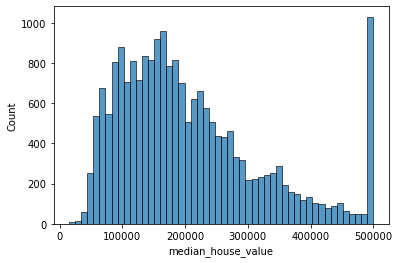

In [11]:
sns.histplot(df.median_house_value, bins=50)

In [12]:
median_house_value_logs=np.log1p(df.median_house_value)

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

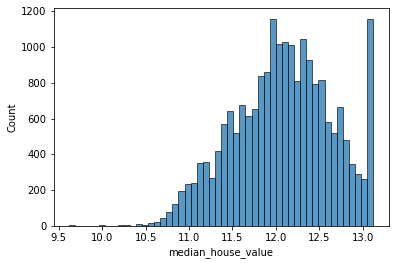

In [13]:
sns.histplot(median_house_value_logs, bins=50)

In [15]:
df = df[(df['ocean_proximity']=='<1H OCEAN')|(df['ocean_proximity']=='INLAND')]

In [16]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [17]:
base = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population',
'households','median_income','median_house_value']

#### QUESTION 1: Missing values

In [18]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

#### QUESTION 2: Median value of the population

In [19]:
df['population'].median()

1195.0

#### SPLITTING THE DATASET

In [20]:
n = len(df)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n-n_val-n_test

In [37]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [38]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [39]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [40]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

#### QUESTION 3

In [41]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [42]:
base = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population',
'households','median_income']
X_train = df_train[base].fillna(0).values
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)

In [43]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [68]:
round(rmse(y_train, y_pred),2)

0.34

In [69]:
X_train = df_train[base].fillna(df_train['total_bedrooms'].mean()).values
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
round(rmse(y_train, y_pred),2)

0.34

#### CONCLUSION: Both are equally good

#### QUESTION 4: Regularized Regression

In [49]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [50]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [51]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.34087793004378303

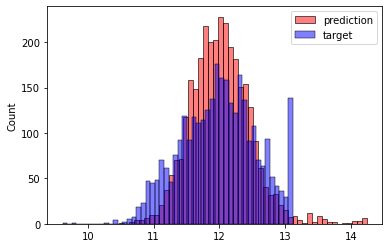

In [52]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

In [53]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0.0 -9.763249477680878 0.3408479034177055
1e-05 -9.763043013986493 0.3408479310589702
0.0001 -9.761185235173034 0.3408481800593494
0.001 -9.742646249273005 0.3408506921852171
0.1 -8.058889769678107 0.34128620419778105
1 -3.1331542784593767 0.34489583276371966
10 -0.4381172315539199 0.3483149833519755


#### QUESTION 5: Does the random seed affect our model?

In [89]:
def seed_split(n):
    np.random.seed(n)
    np.random.shuffle(idx)
    df = pd.read_csv('housing.csv')
    
    base = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population',
    'households','median_income','median_house_value']
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    base = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population',
    'households','median_income']
    
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    return rmse(y_val, y_pred)
    
    
    
    

In [90]:
seeds_rmse = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    seeds_rmse.append([i,seed_split(i)])
    

In [91]:
seeds_rmse

[[0, 0.3411914731309255],
 [1, 0.3363997415171983],
 [2, 0.3363884158805872],
 [3, 0.34167500011206664],
 [4, 0.35490128741885507],
 [5, 0.34219243314986325],
 [6, 0.3422806119794408],
 [7, 0.3361080455917351],
 [8, 0.35804417363939123],
 [9, 0.3447900083152577]]

In [92]:
seeds_rmse = pd.DataFrame(seeds_rmse, columns=['rand_seed', 'rmse'])

In [96]:
round(np.std(seeds_rmse['rmse']),3)

0.007

#### QUESTION 6: Using the model

In [97]:
np.random.seed(9)
np.random.shuffle(idx)

df=pd.read_csv('housing.csv')
base = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population',
'households','median_income','median_house_value']


df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]


y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


base = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population',
'households','median_income']

In [98]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = prepare_X(df_full_train)

In [99]:
y_full_train = np.concatenate([y_train, y_val])
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [100]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

0.33367812392211094